# 설명
- radiance hint generation을 위한 envmap 생성을 위한 trial code
- 

In [23]:
# envs
import torch
import numpy as np
import matplotlib.pyplot as plt
TINY_NUMBER = 1e-8

In [3]:
# paths
light_db_path = "/data1/common_datasets/openillumination/light_pos.npy"

In [14]:
"""
보아하니 OLAT -> SG -> Envmap으로 변환을 해야 하는 것으로 보인다.

SG parameter라고 하는데,
lobe_size = 236.97054
light_intensity = 5
light_positions = light_pos.npy
    (142, 3) shape의 numpy array인데 뭘 의미 하는 것이지? -> 이건 OLAT 용이라서 사용 불가

https://drive.google.com/file/d/1BPcmdoFESLzwSaC-76CX1sPEKBGekdr0/view
여기서 저자 rendering한 environmental map과 전 단게인 SG parameter는 취득 완료

"""

def SG2Envmap(lgtSGs, H, W, upper_hemi=False):
    """
    https://github.com/oppo-us-research/OpenIlluminationCapture/issues/2#issuecomment-1790001568
    
    we provide SG parameters of each light in our paper, which are 236.97054 for lobe size, 5 for light intensity, and the light positions are available in light_pos.npy.
    You can use these parameters to construct each light's SG function and convert it into environment map accordingly
    
    """
    # exactly same convetion as Mitsuba, check envmap_convention.png
    if upper_hemi:
        phi, theta = torch.meshgrid([torch.linspace(0., np.pi/2., H), torch.linspace(-0.5*np.pi, 1.5*np.pi, W)])
    else:
        phi, theta = torch.meshgrid([torch.linspace(0., np.pi, H), torch.linspace(-0.5*np.pi, 1.5*np.pi, W)])

    viewdirs = torch.stack([torch.cos(theta) * torch.sin(phi), torch.cos(phi), torch.sin(theta) * torch.sin(phi)],
                           dim=-1)    # [H, W, 3]
    # print(viewdirs[0, 0, :], viewdirs[0, W//2, :], viewdirs[0, -1, :])
    # print(viewdirs[H//2, 0, :], viewdirs[H//2, W//2, :], viewdirs[H//2, -1, :])
    # print(viewdirs[-1, 0, :], viewdirs[-1, W//2, :], viewdirs[-1, -1, :])

    # lgtSGs = lgtSGs.clone().detach()
    viewdirs = viewdirs.to(lgtSGs.device)
    viewdirs = viewdirs.unsqueeze(-2)  # [..., 1, 3]
    # [M, 7] ---> [..., M, 7]
    dots_sh = list(viewdirs.shape[:-2])
    M = lgtSGs.shape[0]
    lgtSGs = lgtSGs.view([1,]*len(dots_sh)+[M, 7]).expand(dots_sh+[M, 7])
    # sanity
    # [..., M, 3]
    lgtSGLobes = lgtSGs[..., :3] / (torch.norm(lgtSGs[..., :3], dim=-1, keepdim=True) + TINY_NUMBER)
    lgtSGLambdas = torch.abs(lgtSGs[..., 3:4])
    lgtSGMus = torch.abs(lgtSGs[..., -3:])  # positive values
    # [..., M, 3]
    rgb = lgtSGMus * torch.exp(lgtSGLambdas * (torch.sum(viewdirs * lgtSGLobes, dim=-1, keepdim=True) - 1.))
    rgb = torch.sum(rgb, dim=-2)  # [..., 3]
    envmap = rgb.reshape((H, W, 3))
    return envmap


In [ ]:
"""
이제는 DiLgihtNet에서 어떻게 environment map을 받아들이는 지 확인해야 할 필요가 있다.

1. DiLgihtNet training code 가져오기
1.a. training 구동
    - 유의할 점은 mask는 explicit하게 가져오는 것으로 한다.
    - depth의 경우에는 colmap으로 explicit하게 계산하는게 나으려나 했는데, depth foundation model들이 그냥 잘하지 않을까 싶다...
    
2. 그에 따라서 directory refactoring 
3. 전체 process는 원래 image scale에서 다 처리하고, DiLightNet input 전에 cropping하는 것으로 해야 겠다.

오잉 생각보다 전체 dataset이 훨씬 scarse 하다. 1만개도 안되는데...?
64 (number of objects) * 13 (number of lightning conditions) * 10 (number of view points) = 8320

전체 생성해야하는 것은?
radiance hint for all (training, validation)
64 * view_points  * 13 * 3
64개의 object에 대해서,

개인적으로는 CFG처럼 viewpoint을 일종의 class처럼 활용할 수 있다면, controlNet이 훨씬 fitting을 잘 할 거 같기는 한데...
일단은 빨리 데이터 뽑고, baseline 돌리고 report 해보자.



1. 데이터 뽑기
병렬화 시켜서
2. 학습... 이건 뭐 그냥 huggingface framework이라서
For training, use image pairs (condition and output) that capture the same object at the same camera pose, differing only in lighting conditions
다만, source image에 대해서 같은 view point이나 다른 light condition을 지니도록 해야함

"""

In [43]:
# light pos pack
temp_sgs = "/data1/common_datasets/openillumination/generate_light_gt_sg/sgs/002.npy"

raw_sgs_001 = np.load(temp_sgs)
result = SG2Envmap(torch.tensor(raw_sgs_001), 512, 1024, upper_hemi=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.0760815962231303e-128..1.000216717304759].


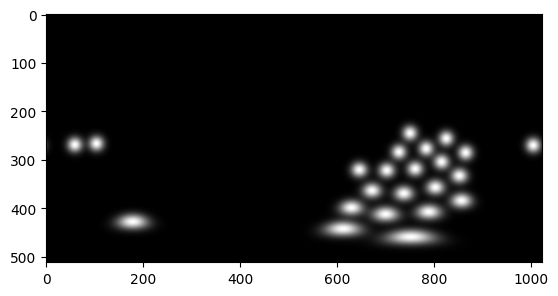

In [44]:
image = plt.imshow(result.numpy())

In [42]:
raw_sgs_001

array([[-3.73956999e-01, -2.40801287e-01, -8.95639940e-01,
         2.36970500e+02,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00],
       [ 1.26246830e-01, -2.53541039e-01, -9.59050926e-01,
         2.36970500e+02,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00],
       [ 4.17920084e-01, -3.55333121e-01, -8.36110744e-01,
         2.36970500e+02,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00],
       [ 6.55910388e-01, -3.30278847e-01, -6.78746968e-01,
         2.36970500e+02,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00],
       [-3.30365586e-01, -4.99105007e-01, -8.01094734e-01,
         2.36970500e+02,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00],
       [ 1.81214730e-01, -5.06592898e-01, -8.42926365e-01,
         2.36970500e+02,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00],
       [-3.22525309e-01, -7.47452890e-01, -5.80768114e-01,
         2.36970500e+02,  1.00000000e+00,  1.00000000e+00,
         1.0000000